# Annexure A : Code

## Problem Definition
To Predict the winners of UFC Fights from each fighters' statistics prior to the fight. 
## Introduction
In this report, we predict the results of MMA fights in the  Ultimate Fighting Championship (UFC) using machine learning algorithms. From past fights we created a feature set that includes fight result and player performance,which is broken down into various other features like number of kicks,punches etc. Using this data we formed decision trees in order to predict results of future fights. Our prediction is in one of four classes for each game: win, loss, draw or no contest. We're evaluating the following models: Perceptron,Random Forests,Decision Trees Classifier,SGD Classifier,Linear SVM,Gaussian NB,KNN,XGBoosted Trees.
### Background
 MMA (Mixed Martial Arts) has developed gradually from barbaric, organised brawls to the fastest growing sport in the world, mainly because of the broadening of Ultimate Fighting Championship (UFC). Due to increase in popularity and love for the game we decided to create a prediction model for obtaining the results of a MMA fight. It has many real life applications such as gambling, journalism and improvement of player performance by scrutinizing the advantages of the other opponents and refining his own performance in accordance to that data. Today, the popularity of the UFC has exceeded all other fighting sports and now consistently achieves more pay-per-view (PPV) buys than boxing and even rivalling the WWE and hence we have settled on UFC for our prediction model. 
### Relevant Work
Sports data has been well recorded and analysed. There have been many attempts to analyse baseball data , predicting the soccer match results by Ben Ulmer and Matthew Fernandez in which they use 8 different models to get the end result . Firstly they used the baseline model to reduce their 3 class classification to a only 2 class classification problem. Further naive bayes model , hidden markov model , support vector machines and random forest models were used. The least error in the data was given by the stochastic gradient descent model. But there have not been many attempts at analysing the data related to MMA(Mixed Martial Arts). One attempt comes from the article: “Betting on UFC Fights - A Statistical Data Analysis”, which uses a random forest classifier to extract several results from the data. Unfortunately, decision tree learning tends to overfit on training data, so in our case it may not be a good idea to use this method. Regardless, even if we uncover a model that can predict accurately the outcome of a match, the model itself will not be complete since we are not incorporating the fact that previous matches for a Fighter A may influence the outcome of his/her next match.
Another attempt has been made by Ivan Suarez Robles and Joseph Wu to analyse and predicting  the outcome of a fight  between the two fighters. They are using three different types of learning algorithm for predicting the outcome of each UFC match which are the  Naive Bayes classifier, Logistic Regression, Support Vector Machines (SVMs). They have  also implemented K-means clustering to help categorize different styles of fighting and observe any trends between matches of different clusters.  
## Data Description and Background
Since our problem domain has never been implemented before, we had to analyse a lot of raw data to create our dataset. The UFC itself is provided data by an organization called FightMetric. FightMetric also offers a paid API service for people who want to get access to data. Since we did not have the resources to purchase this API, we ended up writing several scrapers in Python and Beautiful Soup to get access to data from the UFC website. We further used a Javascript API that pulls some of the fighter data from ufc.com. 
Further we had to write scripts to extract all the features from our JSONs objects that the scraper returned and convert them into a final cleaned up version of a CSV. 
Further since the Fightmetric APIs only provide fighter models - they provide either the most recent or an all time average of the fighter's statistics - this was not very helpful as we wanted to figure out how each fighter's statistics looked prior to each fight. Since highly granular data was only available post 2013, we were forced to start every fighter from point 0 at the beginning of 2014. We had to tally the records of every fight the fighter fought and add it to a running total, to get a snapshot of the fighter's statistics before each fight. 

In [1]:
"""
    A simple scraper to retrieve data from www.ufc.com
    in a predictable/easily machine readable format

    Copyright (c) 2016, Adrian Goris

    Permission to use, copy, modify, and/or distribute this software for any
    purpose with or without fee is hereby granted, provided that the above
    copyright notice and this permission notice appear in all copies.

    THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES
    WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF
    MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR
    ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
    WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
    ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF OR
    IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
"""

import codecs
import csv
import datetime
from bs4 import BeautifulSoup
import requests
import cStringIO
import pprint

class Scraper(object):

    """A collection of functions which can be used to retrieve and parse fight related data from sherdog.com"""

    # Base URL for all requests
    base_url = 'http://www.ufc.com'

    #----------------------------------+
    #  Dict object for Fighter
    #----------------------------------+
    fighter = {
        "name": "",
        "nickname": "",
        "fullname": "",
        "hometown": "",
        "location": "",
        "age": "",
        "height": "",
        "height_cm": "",
        "weight": "",
        "weight_kg": "",
        "record": "",
        "college": "",
        "degree": "",
        "summary": [],
        "strikes": {
          "attempted": 0,
          "successful": 0,
          "standing": 0,
          "clinch": 0,
          "ground": 0
          },
        "takedowns": {
          "attempted": 0,
          "successful": 0,
          "submissions": 0,
          "passes": 0,
          "sweeps": 0
        },
        "fights": []
      };


    @classmethod
    def fetch_url(self, url):

        # Fetch a url and return it's contents as a string

        uf = requests.get(url)
        return uf.text

    @classmethod
    def isNone(self, x):

        # Simple check if an object is None for use in building list comprehensions

        if x is not None:
            return False
        else:
            return True

    def name(self, soup):
        
        # Get the fighter's name from the supplied html soup
        
        try:
            name = soup.find('div', {'id' : 'fighter-details' })
            name = soup.find('h1').get_text()
        except AttributeError:
            name = None
        self.fighter["name"] = name
        return name

    def nickname(self, soup):

        # Get the fighter's nickname from the supplied html soup

        try:
            nickname = soup.find('td', {'id' : 'fighter-nickname' }).get_text()
        except AttributeError:
            nickname = None
        self.fighter["nickname"] = nickname
        return nickname

    def fullname(self, soup):

        # Get the fighter's full name from the supplied html soup

        try:
            fullname = soup.title.get_text()
            fullname = fullname.split("-")[0]
        except AttributeError:
            fullname = None
        self.fighter["fullname"] = fullname
        return fullname

    def hometown(self, soup):

        # Get the fighter's hometown from the supplied html soup
        # TODO: Remove line breaks, returns, and whitespaces

        try:
            hometown = soup.find('td', {'id' : 'fighter-from' }).get_text()
            hometown = hometown.strip()
        except AttributeError:
            hometown = None
        self.fighter["hometown"] = hometown
        return hometown

    def location(self, soup):

        # Get the fighter's listed location from the supplied html soup
        # TODO: Remove line breaks, returns, and whitespaces

        try:
            location = soup.find('td', {'id' : 'fighter-lives-in' }).get_text()
            location = location.strip()
        except AttributeError:
            location = None
        self.fighter["location"] = location
        return location

    def age(self, soup):

        # Get the fighter's age from the supplied html soup

        try:
            age = soup.find('td', {'id' : 'fighter-age' }).get_text()
            age = age.strip()
        except AttributeError:
            age = None
        self.fighter["age"] = age
        return age

    
    def height(self, soup):

        # Get the fighter's height from the supplied html soup
        # TODO: Break out into a dict for imperial and metric

        try:
            height = soup.find('td', {'id' : 'fighter-height' }).get_text()
            height = height.strip()
        except AttributeError:
            height = None
        self.fighter["height"] = height
        return height

    def weight(self, soup):

        # Get the fighter's weight from the supplied html soup
        # TODO: Break out into a dict for imperial and metric

        try:
            weight = soup.find('td', {'id' : 'fighter-weight' }).get_text()
            weight = weight.strip()
        except AttributeError:
            weight = None
        self.fighter["weight"] = weight
        return weight

    def record(self, soup):

        # Get the fighter's height from the supplied html soup
        # TODO: Break out into a dict for wins, loses, ties

        try:
            record = soup.find('td', {'id' : 'fighter-skill-record' }).get_text()
            record = record.strip()
        except AttributeError:
            record = None
        self.fighter["record"] = record
        return record

    def college(self,soup):

        # Get the fighter's college from the supplied html soup

        try:
            college = soup.find('td', {'id' : 'fighter-college' }).get_text()
            college = college.strip()
        except AttributeError:
            college = None
        self.fighter["college"] = college
        return college

    def degree(self,soup):

        # Get the fighter's height from the supplied html soup
        # TODO: Break out into a dict for wins, loses, ties

        try:
            degree = soup.find('td', {'id' : 'fighter-degree' }).get_text()
            degree = degree.strip()
        except AttributeError:
            degree = None
        self.fighter["degree"] = degree
        return degree

    def summary(self,soup):

        # Get the fighter's summary from the supplied html soup
        # TODO: Consider breaking out into a dictionary

        try:
            summary = soup.find('td', {'id' : 'fighter-skill-summary' }).get_text()
            summary = summary.strip()
        except AttributeError:
            summary = None
        self.fighter["summary"] = summary
        return summary

    def strikes(self,soup):

        # Get the fighter's strikes from the supplied html soup
        # TODO: CLEAN UP
        # TODO: Add error handleing

        fighter_striking_dict = {}

        # Striking Metrics
        fighter_strikes = soup.find('div', {'id' : 'fight-history' })
        fighter_strikes = fighter_strikes.findAll('div', {'class' : 'overall-stats' })[0]
        
        # Strikes attempted
        fighter_striking_dict["strikes_attempted"] = fighter_strikes.find('div', {'class' : 'max-number' }).get_text()
        # Strikes successfull
        fighter_striking_dict["strikes_successfull"] = fighter_strikes.find('div', {'id' : 'total-takedowns-number' }).get_text()
        
        # Strikes Type
        strikes_type = fighter_strikes.findAll('div', {'class' : 'text-bar' })
        strikes_type = [x.get_text() for x in strikes_type]
        fighter_striking_dict["strikes_standing"] = strikes_type[2]
        fighter_striking_dict["strikes_clinch"] = strikes_type[3]
        fighter_striking_dict["strikes_ground"] = strikes_type[4]

        self.fighter["strikes"] = fighter_striking_dict
        return fighter_striking_dict

    def takedowns(self,soup):

        # Get the fighter's takedowns from the supplied html soup
        # TODO: CLEAN UP
        # TODO: Add error handleing

        fighter_grapeling_dict = {}

        # Grapeling Metrics
        td_attempted = soup.findAll('div', {'class' : 'graph' })[2]
        td_successfull = soup.find('div', {'id' : 'grappling-totals-by-type-graph' })

        # Takedowns attempted
        fighter_grapeling_dict["takedowns_attempted"] = td_attempted.find('div', {'class' : 'max-number' }).get_text()
        # Takedowns successfull
        fighter_grapeling_dict["takedowns_successful"] = td_attempted.find('div', {'id' : 'total-takedowns-number' }).get_text()

        # Takedown type
        fighter_grapeling_dict["takedowns_submissions"] = td_successfull.find('div', {'id' : 'successful-submissions' }).get_text()
        fighter_grapeling_dict["successful_passes"] = td_successfull.find('div', {'id' : 'successful-passes' }).get_text()
        fighter_grapeling_dict["successful_sweeps"] = td_successfull.find('div', {'id' : 'successful-sweeps' }).get_text()

        self.fighter["takedowns"] = fighter_grapeling_dict
        return fighter_grapeling_dict

    def fights(self,soup):

        # Get the fighter's fights from the supplied html soup
        # TODO: CLEAN UP
        # TODO: Add error handleing

        fights = []

        fights_table = soup.find('table', {'id' : 'fights-table' }).findAll('tr',{'class':'fight'})

        for item in fights_table:
            fight = {}
            fighter = {}
            opponent = {}
            
            #tds have no class, or id to identify them by
            tds = item.findAll('td')

            #result
            fight['result'] = None

            #fighter_name
            fighter_name = item.find('td', {'class':'fighter'}).get_text()

            #opponent
            opponent_name = item.find('td', {'class':'fighter'}).get_text()

            #event
            event_dict = {}
            event = item.find('td', {'class':'event'}).get_text()
            event = event.strip().split('\n')
            event_name = event[0].strip()
            event_date = event[-1].strip()

            event_dict['name'] = event_name
            event_dict['date'] = event_date
            fight['event'] = event_dict

            #method
            method = item.find('td', {'class':'method'}).get_text()
            method = method.strip()
            fight['method'] = method

            #replay
            replay = item.find('td', {'class':'last'}).get_text()
            replay = replay.strip()
            fight['replay'] = replay

            #awards
            awards = item.find('td', {'class':'awards'}).get_text()
            awards = awards.strip()
            fight['awards'] = awards


            fight['fighter'] = fighter
            fight['opponent'] = opponent

            #strikes
            strikes = tds[3]    
            strikes = strikes.findAll('div')
            strikes = [x.get_text() for x in strikes]
            # fighter is 0, oppenent is 1
            fight['strikes'] = strikes
            fighter['strikes'] = strikes[0]
            opponent['strikes'] = strikes[1]


            #takedowns
            takedowns = tds[4]
            takedowns = takedowns.findAll('div')
            takedowns = [x.get_text() for x in takedowns]
            # fighter is 0, oppenent is 1
            fight['takedowns'] = takedowns
            fighter['takedowns'] = takedowns[0]
            opponent['takedowns'] = takedowns[1]


            #submissions
            submissions = tds[5]
            submissions = submissions.findAll('div')
            submissions = [x.get_text() for x in submissions]
            # fighter is 0, oppenent is 1
            fight['submissions'] = submissions
            fighter['submissions'] = submissions[0]
            opponent['submissions'] = submissions[1]


            #passes
            passes = tds[6]
            passes = passes.findAll('div')
            passes = [x.get_text() for x in passes]
            fight['passes'] = passes
            fighter['passes'] = passes[0]
            opponent['passes'] = passes[1]


            #end append to list
            fights.append(fight)

        self.fighter["fights"] = fights
        return fights


    def scrape_fighter(self, fighter_slug):

        # Retrieve and parse a fighter's details from www.ufc.com

        # fetch the required url and parse it

        url_content = self.fetch_url('%s/fighter/%s' % (self.base_url, fighter_slug))
        soup = BeautifulSoup(url_content, "html.parser")

        self.name(soup)
        self.nickname(soup)
        self.fullname(soup)
        self.hometown(soup)
        self.location(soup)
        self.age(soup)
        self.height(soup)
        self.weight(soup)
        self.record(soup)
        self.college(soup)
        self.degree(soup)
        self.summary(soup)
        self.strikes(soup)
        self.takedowns(soup)
        self.fights(soup)

        return self.fighter


class UnicodeWriter:

    """
    A CSV writer which will write rows to CSV file "f",
    which is encoded in the given encoding.
    """

    def __init__(self, f, dialect=csv.excel, encoding="utf-8", **kwds):
        # Redirect output to a queue
        self.queue = cStringIO.StringIO()
        self.writer = csv.writer(self.queue, dialect=dialect, **kwds)
        self.stream = f
        self.encoder = codecs.getincrementalencoder(encoding)()

    def writerow(self, row):
        try:
            self.writer.writerow([s.encode("utf-8") for s in row])
        except UnicodeDecodeError:
            self.writer.writerow(row)
        # Fetch UTF-8 output from the queue ...
        data = self.queue.getvalue()
        data = data.decode("utf-8")
        # ... and reencode it into the target encoding
        data = self.encoder.encode(data)
        # write to the target stream
        self.stream.write(data)
        # empty queue
        self.queue.truncate(0)

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

if __name__ == '__main__':

    # TODO: Remove Jon Jones Hard code
    # http://www.ufc.com/fighter/Jon-Jones
    
    scraper = Scraper()
    fighter = scraper.scrape_fighter("Jon-Jones")
    pprint.pprint(fighter)




{'age': u'30',
 'college': u'Iowa Central',
 'degree': u'Associates Degree',
 'fights': [{'awards': u'Performance of the Night',
             'event': {'date': u'Jul 29, 2017',
                       'name': u'UFC 214 Cormier vs Jones 2:Live on Pay-Per-View'},
             'fighter': {'passes': u'0',
                         'strikes': u'58',
                         'submissions': u'0',
                         'takedowns': u'0'},
             'method': u'R3\n\t\t\t\t\tOverturned',
             'opponent': {'passes': u'0',
                          'strikes': u'95',
                          'submissions': u'0',
                          'takedowns': u'0'},
             'passes': [u'0', u'0'],
             'replay': u'',
             'result': None,
             'strikes': [u'58', u'95'],
             'submissions': [u'0', u'0'],
             'takedowns': [u'0', u'0']},
            {'awards': u'',
             'event': {'date': u'Apr 23, 2016',
                       'name': u'UFC 197

In [4]:
import json
fighter = json.dumps(fighter)

In [6]:
fighter_data = json.loads(fighter)
fighter_data

{u'age': u'30',
 u'college': u'Iowa Central',
 u'degree': u'Associates Degree',
 u'fights': [{u'awards': u'Performance of the Night',
   u'event': {u'date': u'Jul 29, 2017',
    u'name': u'UFC 214 Cormier vs Jones 2:Live on Pay-Per-View'},
   u'fighter': {u'passes': u'0',
    u'strikes': u'58',
    u'submissions': u'0',
    u'takedowns': u'0'},
   u'method': u'R3\n\t\t\t\t\tOverturned',
   u'opponent': {u'passes': u'0',
    u'strikes': u'95',
    u'submissions': u'0',
    u'takedowns': u'0'},
   u'passes': [u'0', u'0'],
   u'replay': u'',
   u'result': None,
   u'strikes': [u'58', u'95'],
   u'submissions': [u'0', u'0'],
   u'takedowns': [u'0', u'0']},
  {u'awards': u'',
   u'event': {u'date': u'Apr 23, 2016',
    u'name': u'UFC 197 Jones vs. Saint Preux:Live on Pay-Per-View'},
   u'fighter': {u'passes': u'4',
    u'strikes': u'105',
    u'submissions': u'0',
    u'takedowns': u'3'},
   u'method': u'R5\n\t\t\t\t\tDecision - Unanimous',
   u'opponent': {u'passes': u'0',
    u'strikes': 

In [13]:
fighter_data['fights']

[{u'awards': u'Performance of the Night',
  u'event': {u'date': u'Jul 29, 2017',
   u'name': u'UFC 214 Cormier vs Jones 2:Live on Pay-Per-View'},
  u'fighter': {u'passes': u'0',
   u'strikes': u'58',
   u'submissions': u'0',
   u'takedowns': u'0'},
  u'method': u'R3\n\t\t\t\t\tOverturned',
  u'opponent': {u'passes': u'0',
   u'strikes': u'95',
   u'submissions': u'0',
   u'takedowns': u'0'},
  u'passes': [u'0', u'0'],
  u'replay': u'',
  u'result': None,
  u'strikes': [u'58', u'95'],
  u'submissions': [u'0', u'0'],
  u'takedowns': [u'0', u'0']},
 {u'awards': u'',
  u'event': {u'date': u'Apr 23, 2016',
   u'name': u'UFC 197 Jones vs. Saint Preux:Live on Pay-Per-View'},
  u'fighter': {u'passes': u'4',
   u'strikes': u'105',
   u'submissions': u'0',
   u'takedowns': u'3'},
  u'method': u'R5\n\t\t\t\t\tDecision - Unanimous',
  u'opponent': {u'passes': u'0',
   u'strikes': u'57',
   u'submissions': u'0',
   u'takedowns': u'0'},
  u'passes': [u'4', u'0'],
  u'replay': u'',
  u'result': None,

In [14]:
from unicodecsv import DictWriter
with open("test.csv", 'w') as f:
    writer = DictWriter(f,fieldnames = fighter_data['fights'][0].keys())
    writer.writeheader()
    for fight in fighter_data['fights']:
        writer.writerow(fight)

In [1]:
# Imports and Helper Functions
# data Analysis
import pandas as pd
import numpy as np
import random as rng

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from subprocess import check_output
print(check_output(["ls", "../input/ufcdataset"]).decode("utf8"))
data = pd.read_csv("../input/ufcdataset/data.csv")
# Any results you write to the current directory are saved as output.

data.csv



In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 895 entries, BPrev to winner
dtypes: float64(873), int64(13), object(9)
memory usage: 10.1+ MB


## Description
From this, we can see that we have a total of 879 Columns and one dependent variable. 
The columns themselves have 4 integer types (Streaks, Previous Wins etc), 5 object types (Names, Winner - basically strings and arrays) and 870 Float types. 
This however does not give us a complete picture of our data, so we're using a few other pandas functions to get a better glimpse. 
We also had to engineer a few features that weren't available in the JSONs as explained in the data explanation in the introduction of the project. 

In [3]:
data.describe()

,BPrev,BStreak,B_Age,B_Height,B_ID,B_Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,B__Round1_Grappling_Takedowns_Attempts,...,R__Round5_TIP_Distance Time,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time
count,1477.000000,1477.000000,1474.000000,1476.000000,1477.000000,1477.000000,978.000000,978.000000,978.000000,978.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.735274,0.654705,30.954545,177.451220,1964.633040,73.804333,0.036810,0.896728,0.431493,2.986708,...,211.965278,34.062500,66.604167,5.527778,4.319444,5.138889,12.097222,224.965278,4.562500,263.069444
std,1.895561,1.057269,4.020311,8.561541,666.949141,14.980531,0.193748,1.255722,0.830527,3.987291,...,139.412374,68.819742,94.574736,22.374419,12.854023,14.312013,36.429320,142.328509,19.698681,162.386212
min,0.000000,0.000000,20.000000,152.000000,129.000000,52.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,172.000000,1755.000000,65.000000,0.000000,0.000000,0.000000,0.000000,...,110.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.750000,0.000000,139.000000
50%,1.000000,0.000000,31.000000,177.000000,2156.000000,70.000000,0.000000,0.000000,0.000000,2.000000,...,214.000000,0.000000,9.500000,0.000000,0.000000,0.000000,0.000000,232.000000,0.000000,291.000000
75%,3.000000,1.000000,34.000000,182.000000,2337.000000,84.000000,0.000000,1.000000,1.000000,4.000000,...,294.500000,47.500000,109.000000,0.000000,0.000000,0.000000,2.000000,299.000000,0.000000,300.000000
max,11.000000,7.000000,46.000000,213.000000,2882.000000,120.000000,2.000000,9.000000,6.000000,33.000000,...,647.000000,496.000000,529.000000,144.000000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [4]:
data.describe(include=['O'])

,B_HomeTown,B_Location,B_Name,Date,R_HomeTown,R_Location,R_Name,winby,winner
count,1471,1470,1477,1477,1477,1476,1477,1461,1477
unique,568,431,719,224,495,390,633,3,4
top,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Tim Means,07/11/2016,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Donald Cerrone,DEC,red
freq,32,38,8,32,44,67,11,720,867


### Some Notes to observe
1. Red Side seems to win slightly more than blue (867/1477 = 58.7%)
2. Donald Cerrone fights on Red side more than any other fighter, with 11 fights
3. Tim Means fights on Blue side more than any other fighter with 8
4. There are more fighters fighting debut fights. This statistic however could be skewed by the fact that our data set assumes debuts of every fighter in 2013
5. Most Fights are won by decision, and 2015 had the most fights. 
6. The Most common hometown and training location for fighters is Rei De Janeiro in Brazil
We also notice that 3 fighters don't have an age and 1 doesn't have a height. 

In [5]:
data.head()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
0,1,1,23.0,182.0,Trento Italy,2783,Mezzocorona Italy,Marvin Vettori,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
2,2,0,38.0,172.0,Kanagawa Japan,721,Tokyo Japan,Takanori Gomi,70,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KO/TKO,red
3,0,0,23.0,170.0,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
4,3,1,30.0,167.0,"Spokane, WA USA",2260,"Spokane, WA USA",Elizabeth Phillips,61,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red


In [6]:
data.tail()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1472,0,0,26.0,172.0,"Tlaltenango, Zacatecas Mexico",2355,"San Diego, California USA",Jose Quinonez,61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1473,2,1,26.0,165.0,"Tampa, Florida USA",2610,"Tampa, Florida USA",Geane Herrera,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1474,3,2,36.0,187.0,"Doylestown, Pennsylvania USA",1694,"Dana Point, California USA",Patrick Cummins,93,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,blue
1475,3,1,31.0,167.0,Irvine Scotland,2339,Glasgow Scotland,Joanne Calderwood,52,0.0,...,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,KO/TKO,blue
1476,2,1,31.0,187.0,The Netherlands,786,"Leiden, Holland The Netherlands",Gegard Mousasi,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,red


Using the head() and tail() function calls of pandas lets us look at individual rows. In this case, we notice that a large number of columns in our dataset have NaN or Not a Number as an entry - this is how pandas interprets an empty field from our CSV. The reason the NaN values exist is because we have assumed that every fighter starts from zero in 2013. This means that before their first fight in the time beyond 2013, their previous record is blank. 

Pandas by default has two methods of dealing with NaN Values we can choose to either replace them with a value or drop them entirely.
Since it is highly unlikely that any of our dataset has a value that isn't null, we chose to replace all the NaN with the value 0 instead. 

In [7]:
data.fillna(value=0,inplace=True)

In [8]:
data.tail()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1472,0,0,26.0,172.0,"Tlaltenango, Zacatecas Mexico",2355,"San Diego, California USA",Jose Quinonez,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1473,2,1,26.0,165.0,"Tampa, Florida USA",2610,"Tampa, Florida USA",Geane Herrera,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1474,3,2,36.0,187.0,"Doylestown, Pennsylvania USA",1694,"Dana Point, California USA",Patrick Cummins,93,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,blue
1475,3,1,31.0,167.0,Irvine Scotland,2339,Glasgow Scotland,Joanne Calderwood,52,0.0,...,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,KO/TKO,blue
1476,2,1,31.0,187.0,The Netherlands,786,"Leiden, Holland The Netherlands",Gegard Mousasi,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,red


As you can see, the NaN have all been replaced with the value zero. 
Futher, it would behove us to remove identifying information from our model. And Since the Streaks and Previous Fight Columns have already been engineered, The Age Column has not been adjusted for each individual fight, but since our data is only 3 years old, it does not seem worth the effort to make an adjustment. +-3 from both fighters will add to about a .01% inaccuracy once we have combined our features. 

In [9]:
dropdata = data.drop(['B_ID','B_Name','R_ID','R_Name','winby','Date'],axis=1)
dropdata.rename(columns={'BPrev':'B__Prev',
                         'RPrev':'R__Prev',
                         'B_Age':'B__Age',
                         'B_Height':'B__Height',
                         'B_Weight':'B__Weight',
                         'R_Age':'R__Age',
                         'R_Height':'R__Height',
                         'R_Weight':'R__Weight',
                         'BStreak':'B__Streak',
                         'RStreak': 'R__Streak'},inplace=True)
dropdata.describe()

,B__Prev,B__Streak,B__Age,B__Height,B__Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,B__Round1_Grappling_Takedowns_Attempts,B__Round1_Grappling_Takedowns_Landed,...,R__Round5_TIP_Distance Time,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,...,1477.000000,1477.000000,1477.000000,1477.00000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,1.735274,0.654705,30.891672,177.331077,73.804333,0.024374,0.593771,0.285714,1.977657,0.801625,...,20.665538,3.320921,6.493568,0.53893,0.421124,0.501016,1.179418,21.932972,0.444821,25.647935
std,1.895561,1.057269,4.251308,9.724703,14.980531,0.158590,1.106235,0.705874,3.538432,1.538326,...,76.413344,23.685752,35.456443,7.15484,4.201244,4.708527,11.893653,80.116955,6.279119,92.995938
min,0.000000,0.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,172.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,31.000000,177.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,34.000000,182.000000,84.000000,0.000000,1.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,7.000000,46.000000,213.000000,120.000000,2.000000,9.000000,6.000000,33.000000,17.000000,...,647.000000,496.000000,529.000000,144.00000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [10]:
dropdata.describe(include=['O'])

,B_HomeTown,B_Location,R_HomeTown,R_Location,winner
count,1477,1477,1477,1477,1477
unique,569,432,495,391,4
top,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Rio de Janeiro Brazil,red
freq,32,38,44,67,867


Next we need to convert our object types of columns into categorical columns. This is done to sort by logical order

In [11]:
objecttypes = list(dropdata.select_dtypes(include=['O']).columns)
for col in objecttypes:
    dropdata[col] = dropdata[col].astype('category')

In [12]:
cat_columns = dropdata.select_dtypes(['category']).columns
dropdata[cat_columns] = dropdata[cat_columns].apply(lambda x: x.cat.codes)
dropdata.info()
dropdata.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 889 entries, B__Prev to winner
dtypes: float64(873), int16(4), int64(11), int8(1)
memory usage: 10.0 MB


,B__Prev,B__Streak,B__Age,B__Height,B_HomeTown,B_Location,B__Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,...,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winner
1472,0,0,26.0,172.0,505,331,61,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1473,2,1,26.0,165.0,491,378,56,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1474,3,2,36.0,187.0,125,110,93,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1475,3,1,31.0,167.0,210,154,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,0
1476,2,1,31.0,187.0,501,209,84,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Data Correlation
While it would otherwise be normal practise to draw a heatmap or correlation matrix of our data to look for linear relationships, this is highly illogical due to the sheer number of features we're currently looking at.  Instead we examine the n largest correlations with our dependent variable (winner) to look for linear relationships - as you can see from the plot below, the relationships (if they exist) are highly non-linear. This suggests that alterations to our Data Set are required. 

Further, it seems that Round 4 statistics for the Red Fighter are the more correlating, this suggests that a split or delta sort of data set should produce better results. 

In [13]:
# Basic Correlation Matrix
# corrmat = data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

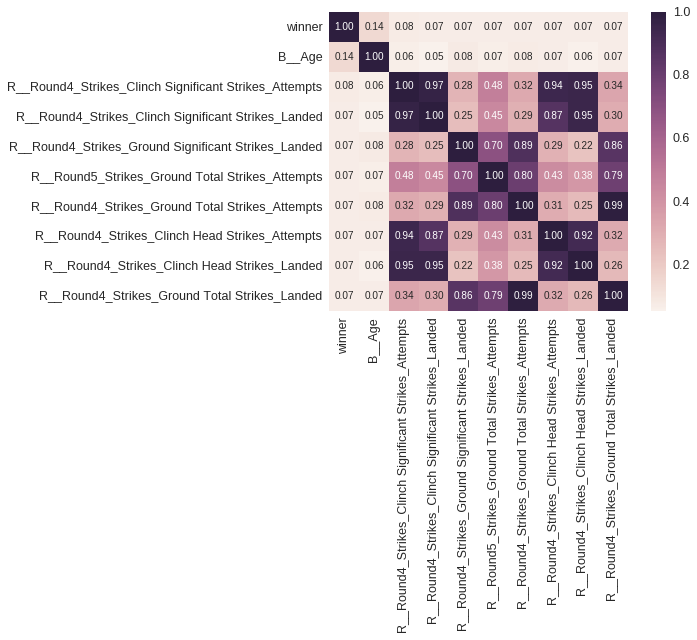

In [14]:
# Subset Correlation Matrix
k = 10 #number of variables for heatmap
corrmat = dropdata.corr()
cols = corrmat.nlargest(k, 'winner')['winner'].index
cm = np.corrcoef(dropdata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Modeling
We're evaluating the following models

1. Perceptron
2. Random Forests
3. Decision Trees Classifier
4. SGD Classifier
5. Linear SVC
6. Gaussian NB
7. KNN

In [15]:
 #We Store prediction of each model in our dict
# Helper Functions for our models. 

def percep(X_train,Y_train,X_test,Y_test,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001)
    perceptron.fit(X_train, Y_train)
    Y_pred = perceptron.predict(X_test)
    Models['Perceptron'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def SGDClass(X_train,Y_train,X_test,Y_test,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001)
    sgd.fit(X_train, Y_train)
    Y_pred = sgd.predict(X_test)
    Models['SGD Classifier'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def linSVC(X_train,Y_train,X_test,Y_test,Models):
    linear_svc = LinearSVC()
    linear_svc.fit(X_train, Y_train)
    Y_pred = linear_svc.predict(X_test)
    Models['SVM'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def Nearest(X_train,Y_train,X_test,Y_test,Models):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Models['KNN'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]

def run_all_and_Plot(df):
    Models = dict()
    from sklearn.model_selection import train_test_split
    X_all = df.drop(['winner'], axis=1)
    y_all = df['winner']
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
    percep(X_train,Y_train,X_test,Y_test,Models)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    SGDClass(X_train,Y_train,X_test,Y_test,Models)
    linSVC(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    Nearest(X_train,Y_train,X_test,Y_test,Models)
    return Models


def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    plt.show()


def plot_cm(dict):
    count = 1
    fig = plt.figure(figsize=(10,10))
    for model in dict:
        cm = dict[model][1]
        labels = ['W','L','N','D']
        ax = fig.add_subplot(4,4,count)
        cax = ax.matshow(cm)
        plt.title(model,y=-0.8)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.subplot(2,2,count)
        count+=1
    plt.tight_layout()
    plt.show()

Perceptron 0.567567567568
Random Forests 0.547297297297
Decision Tree 0.530405405405
SGD Classifier 0.445945945946
SVM 0.39527027027
Bayes 0.381756756757
KNN 0.523648648649


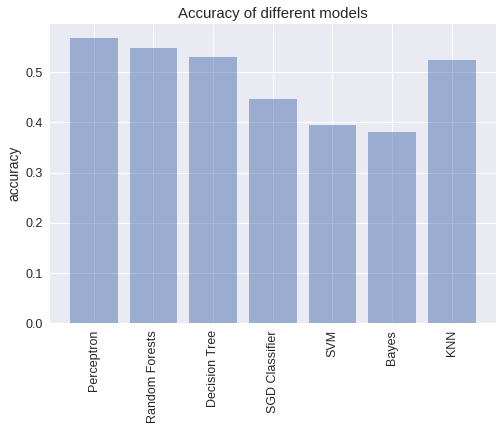

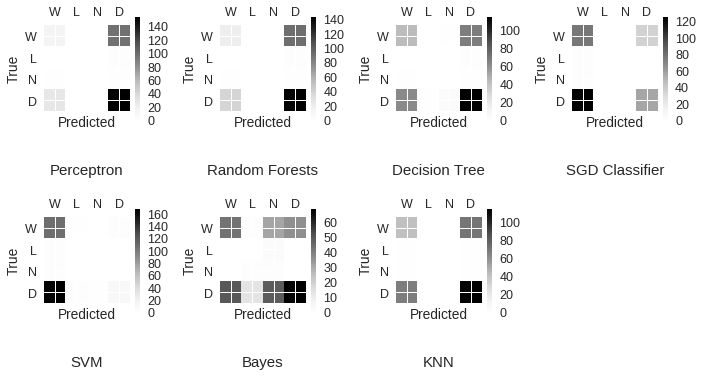

In [16]:
accuracies = run_all_and_Plot(dropdata)
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
plot_bar(accuracies)
plot_cm(accuracies)

Theoretically, we should get best results from our Random Forests Model, thus attempting to tune hyper parameters using GridSearch from Scikit learn

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
#X_all = dropdata.drop(['winner'], axis=1)
#y_all = dropdata['winner']
#X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=23)
#rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=None) 
#param_grid = { 
#    'n_estimators': [200,700],
#    'max_features': ['auto', 'sqrt', 'log2']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train, Y_train)
#print(CV_rfc.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Trying to improve results by dividing features

In [18]:
dontchange = ['winner','Event_ID','Fight_ID','Max_round','Last_round','B_Age','R_Age']
numeric_cols = [col for col in dropdata if col not in dontchange]
dropdata[numeric_cols] += 1 

In [19]:
newDF = dropdata.copy()
blue_cols = [col for col in dropdata.columns if 'B__' in col]
red_cols = [col for col in dropdata.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    dropdata[newkey] = dropdata[str(blue)]/dropdata[str(red)]
    del dropdata[str(blue)]
    del dropdata[str(red)]

Perceptron 0.611486486486
Random Forests 0.584459459459
Decision Tree 0.510135135135
SGD Classifier 0.554054054054
SVM 0.371621621622
Bayes 0.324324324324
KNN 0.570945945946


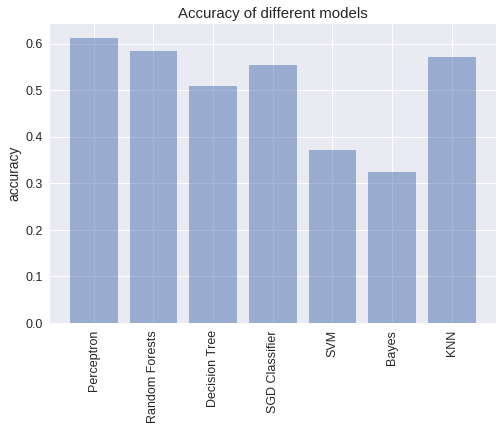

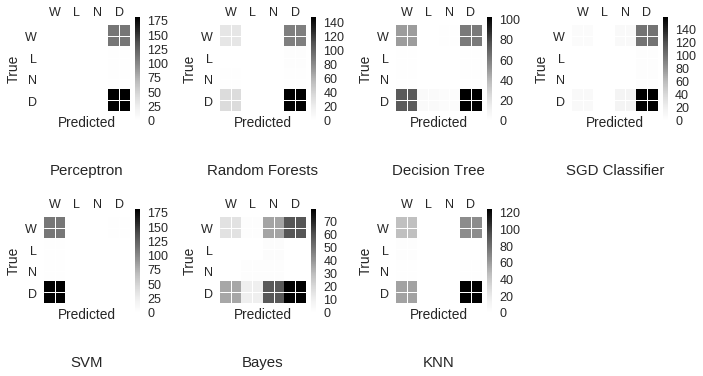

In [20]:
accuracies = run_all_and_Plot(dropdata)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Blue/Red'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


#### Dropping Round 4 and Round 5 since most fights are 3 round Max. 

Perceptron 0.611486486486
Random Forests 0.577702702703
Decision Tree 0.506756756757
SGD Classifier 0.597972972973
SVM 0.591216216216
Bayes 0.347972972973
KNN 0.554054054054


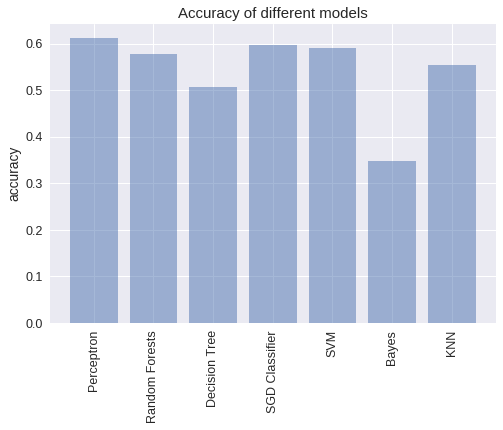

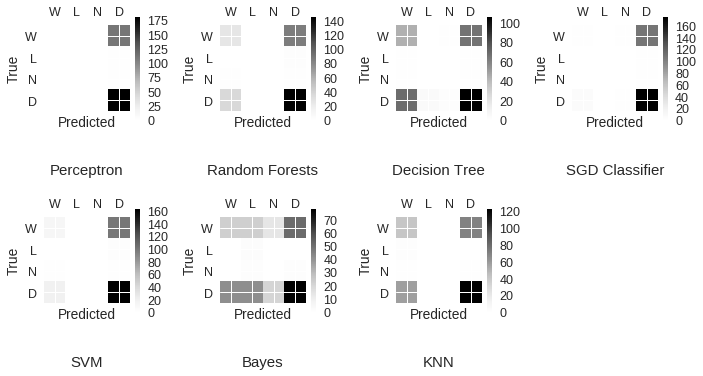

In [21]:
r4 = [col for col in dropdata.columns if "Round4" in col]
r5 = [col for col in dropdata.columns if "Round5" in col]
threerounds = dropdata.drop(r4+r5,axis = 1)
accuracies = run_all_and_Plot(threerounds)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['DropR4&R5'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

#### Dropping 5 round fights entirely

Perceptron 0.611486486486
Random Forests 0.594594594595
Decision Tree 0.513513513514
SGD Classifier 0.375
SVM 0.611486486486
Bayes 0.337837837838
KNN 0.554054054054


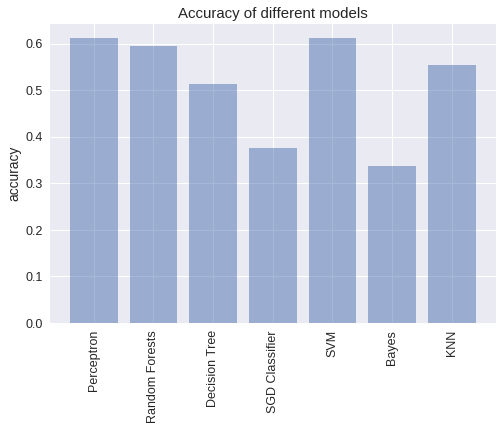

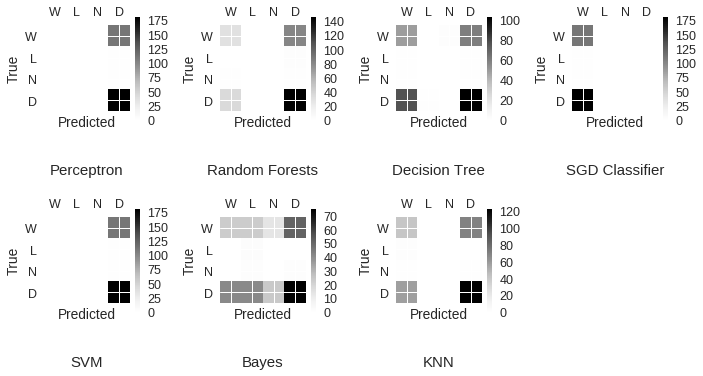

In [22]:
foobar = threerounds.loc[threerounds['Max_round'] == 3]
bewb = threerounds.drop(['Max_round','Last_round'],axis=1)
accuracies = run_all_and_Plot(bewb)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['Drop5RoundFights'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

#### Dropping First Fights

Perceptron 0.541237113402
Random Forests 0.551546391753
Decision Tree 0.546391752577
SGD Classifier 0.556701030928
SVM 0.536082474227
Bayes 0.396907216495
KNN 0.510309278351


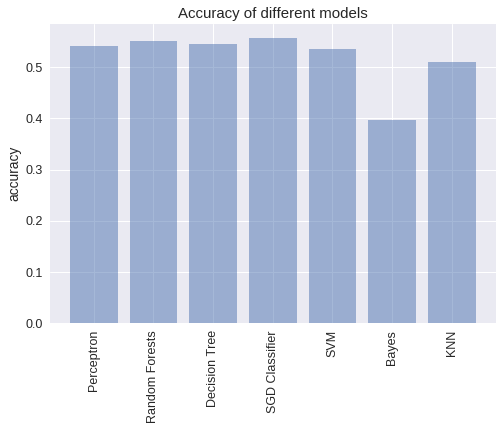

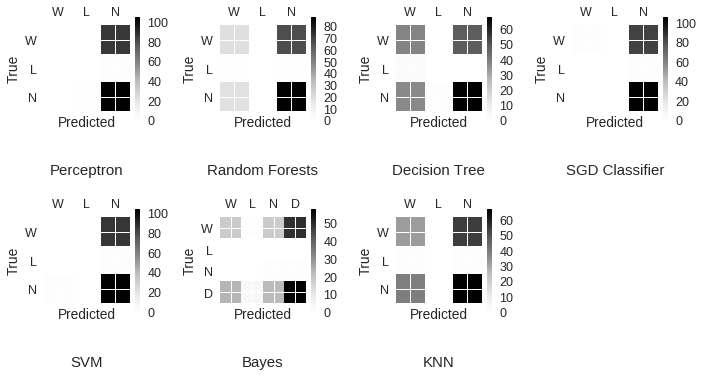

In [23]:
blahblah = bewb[bewb.Prev != 1]
accuracies = run_all_and_Plot(blahblah)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['DroppingDebut'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

In [24]:
blue_cols
newDF.info()
b_feats = list(set([x[10:] for x in blue_cols if "Round" in x]))
r_feats = list(set([x[10:] for x in red_cols if "Round" in x]))
def sumshit(b_feats,cols):
    for x in b_feats:
        newDF.loc[:,x] = 0
        for y in cols:
            if x in y:
                newDF[x] += newDF[y]
                newDF.drop(y,axis=1,inplace=True)
sumshit(b_feats,blue_cols)
sumshit(r_feats,red_cols)
newDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 889 entries, B__Prev to winner
dtypes: float64(873), int16(4), int64(11), int8(1)
memory usage: 10.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 106 entries, B__Prev to Strikes_Clinch Significant Strikes_Attempts
dtypes: float64(90), int16(4), int64(11), int8(1)
memory usage: 1.2 MB


Perceptron 0.611486486486
Random Forests 0.614864864865
Decision Tree 0.557432432432
SGD Classifier 0.429054054054
SVM 0.611486486486
Bayes 0.243243243243
KNN 0.530405405405


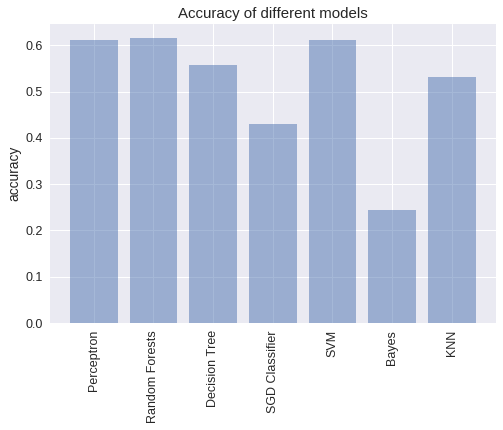

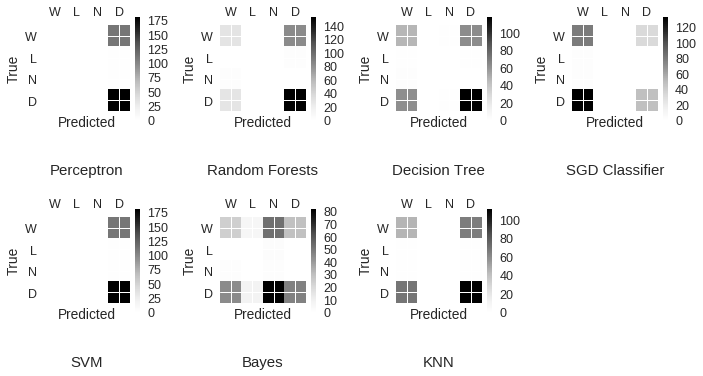

In [25]:
newDF.describe()
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)



In [26]:
blue_cols = [col for col in newDF.columns if 'B__' in col]
red_cols = [col for col in newDF.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    newDF[newkey] = newDF[str(blue)]/newDF[str(red)]
    del newDF[str(blue)]
    del newDF[str(red)]

Perceptron 0.611486486486
Random Forests 0.608108108108
Decision Tree 0.533783783784
SGD Classifier 0.439189189189
SVM 0.557432432432
Bayes 0.253378378378
KNN 0.537162162162


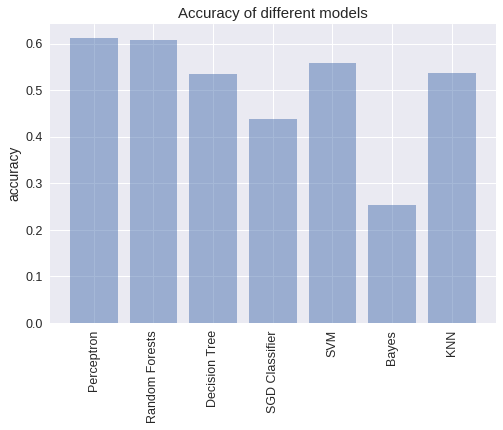

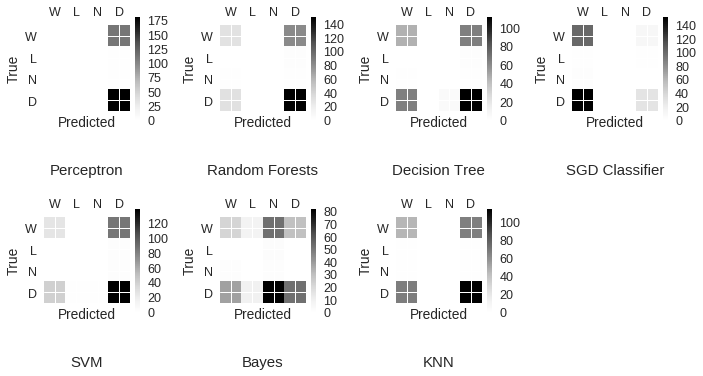

In [27]:
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

Perceptron 0.618243243243
Random Forests 0.577702702703
Decision Tree 0.469594594595
SGD Classifier 0.618243243243
SVM 0.469594594595
Bayes 0.236486486486
KNN 0.52027027027


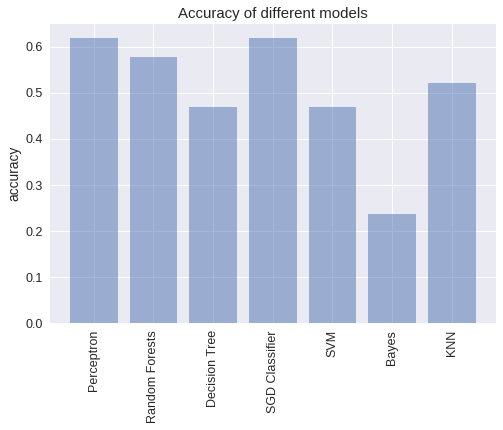

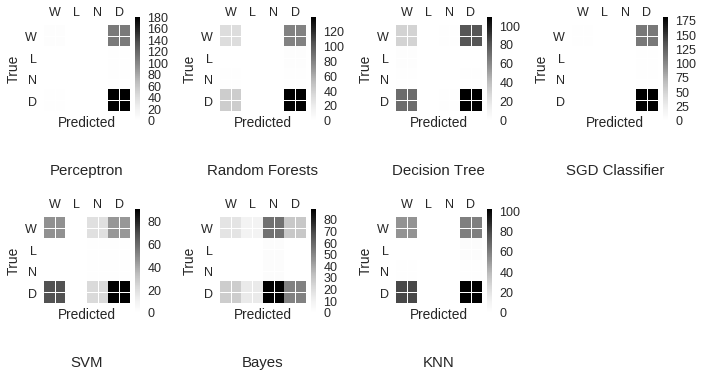

In [28]:
reduced_features = newDF.drop(["Weight","B_HomeTown","B_Location", "Event_ID", "Fight_ID", "Max_round", "Last_round", "R_HomeTown", "R_Location"],axis = 1)
accuracies = run_all_and_Plot(reduced_features)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Idunno'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


In [29]:
reduced_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 92 columns):
winner                                         1477 non-null int8
Strikes_Ground Significant Kicks_Landed        1477 non-null float64
Strikes_Body Significant Strikes_Landed        1477 non-null float64
TIP_Standing Time                              1477 non-null float64
TIP_Neutral Time                               1477 non-null float64
Strikes_Punches_Landed                         1477 non-null float64
Strikes_Punches_Attempts                       1477 non-null float64
Strikes_Clinch Significant Punches_Attempts    1477 non-null float64
Strikes_Clinch Total Strikes_Landed            1477 non-null float64
Strikes_Distance Body Punches_Landed           1477 non-null float64
Strikes_Distance Body Strikes_Attempts         1477 non-null float64
Strikes_Distance Body Kicks_Landed             1477 non-null float64
Strikes_Distance Head Strikes_Attempts         1477 non-null float64

## Conclusion
Our model has a best predictive value that lies between 58-63% on average between runs. Despite a very low accuracy model, we believe this is the best possible given the amount of available data and its inherent noise. 

## Future Work
1. With time, data available should increase
2. Further manipulations with our data set. 
